In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import plotly.express as px
import math

#### beta=relation of a stock with nifty
#### purpose :- build a portfolio such that there is a fixed return regardless of the direction of the market

In [242]:
# Define stock symbols and time period
stocks = ["AARTIIND.NS","MIRZAINT.NS"]
market_symbol = "^NSEI"  # NSE Nifty 50 index symbol
risk_free_rate = 0.0002685  # daily value based on the current risk-free rate
market_risk_premium = 0.0003054  # Adjust this value based on historical data


start_date = "2023-5-03"
end_date = "2023-08-10"

In [243]:
# Download historical data for stocks and market

data = yf.download(stocks + [market_symbol],start=start_date, end=end_date )["Adj Close"]
#data = yf.download(stocks + [market_symbol],period='3mo',interval='1d' )["Adj Close"]
data

[*********************100%***********************]  3 of 3 completed


,AARTIIND.NS,MIRZAINT.NS,^NSEI
Date,,,
2023-05-03,549.901978,59.549999,18089.849609
2023-05-04,550.450134,62.500000,18255.800781
2023-05-05,542.725403,65.599998,18069.000000
2023-05-08,553.241028,62.349998,18264.400391
2023-05-09,555.384033,60.849998,18265.949219
...,...,...,...
2023-08-03,473.700012,47.299999,19381.650391
2023-08-04,472.700012,47.500000,19517.000000
2023-08-07,474.850006,47.049999,19597.300781


In [244]:
# Calculate daily returns for stocks and market
returns = data.pct_change().dropna()

# Separate the market returns from the returns dataframe
market_returns = returns[market_symbol]
stock_returns = returns.drop(columns=[market_symbol])
market_returns-risk_free_rate

Date
2023-05-04    0.008905
2023-05-05   -0.010501
2023-05-08    0.010546
2023-05-09   -0.000184
2023-05-10    0.002422
                ...   
2023-08-03   -0.007689
2023-08-04    0.006715
2023-08-07    0.003846
2023-08-08   -0.001618
2023-08-09    0.002884
Name: ^NSEI, Length: 69, dtype: float64

In [245]:
# Calculate the excess market returns (market risk premium)
excess_market_returns = market_returns - risk_free_rate

In [246]:
cov_matrix = np.cov(stock_returns.values.T, market_returns.values)

# Calculate beta as the covariance between stock and market divided by market variance
betas = [cov_matrix[i, -1] / cov_matrix[-1, -1] for i in range(len(stocks))]
cov_matrix

array([[ 2.83886897e-04, -4.23466409e-05,  2.35227340e-05],
       [-4.23466409e-05,  7.88607028e-04, -1.95909395e-05],
       [ 2.35227340e-05, -1.95909395e-05,  2.88277327e-05]])

In [247]:
# Adjust beta for market risk premium
adj_betas = [beta * (1 + market_risk_premium) for beta in betas]

# Display the calculated adjusted betas
for i, stock in enumerate(stocks):
    print(f"Adjusted Beta of {stock}: {adj_betas[i]}")

Adjusted Beta of AARTIIND.NS: 0.8162250588723677
Adjusted Beta of MIRZAINT.NS: -0.679794097409803


In [248]:
division=np.array([data["AARTIIND.NS"][0],data["MIRZAINT.NS"][0]])
total_stocks=np.array([1,5])
weightage=division*total_stocks/(division@total_stocks)
weightage

array([0.64873556, 0.35126444])

In [249]:
beta_portfolio=weightage.T @ betas
beta_portfolio

0.2906379663117499

In [250]:
data["portfolio"]=np.matmul(total_stocks.T,[data["AARTIIND.NS"],data["MIRZAINT.NS"]])

In [251]:
portfolio_return=data["portfolio"].pct_change().dropna()
portfolio_return.shape

(69,)

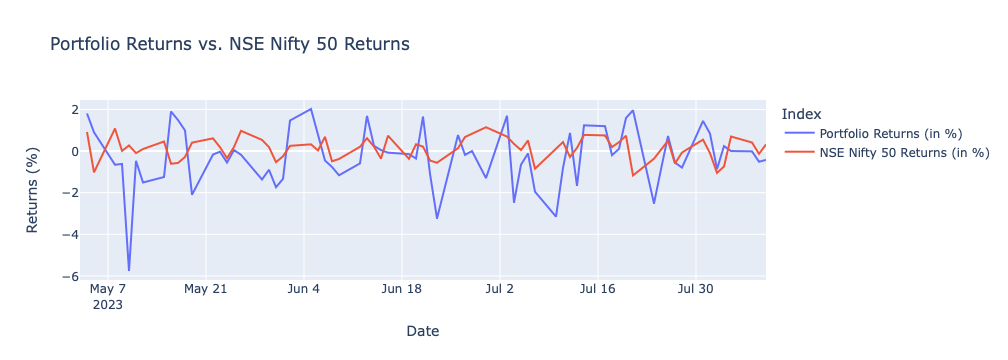

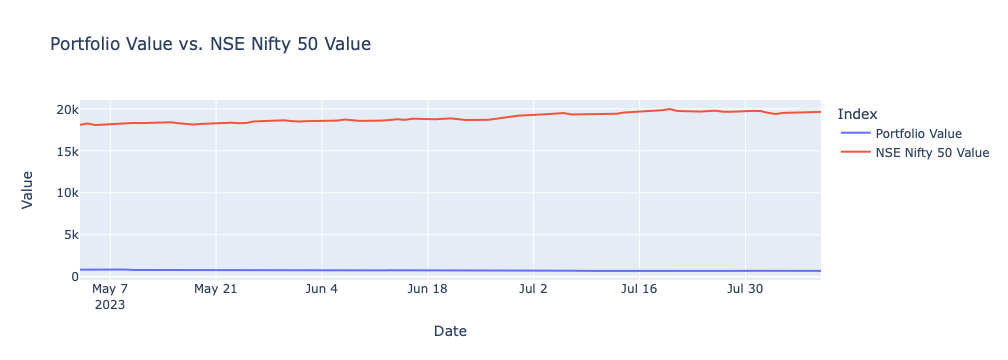

In [252]:
# Create a new dataframe for visualization (returns)
visualization_data_returns = pd.DataFrame({
    "Date": data.index,
    "Portfolio Returns (in %)": data["portfolio"].pct_change() * 100,
    "NSE Nifty 50 Returns (in %)": data[market_symbol].pct_change() * 100
})


# Filter out weekends from the data
filtered_data = data[data.index.weekday < 5]

# Create a new dataframe for visualization (returns)
visualization_data_returns = pd.DataFrame({
    "Date": filtered_data.index,
    "Portfolio Returns (in %)": filtered_data["portfolio"].pct_change() * 100,
    "NSE Nifty 50 Returns (in %)": filtered_data[market_symbol].pct_change() * 100
})

# Plot using Plotly for interactivity (returns)
fig_returns = px.line(visualization_data_returns, x="Date", y=["Portfolio Returns (in %)", "NSE Nifty 50 Returns (in %)"],
                      labels={"value": "Returns (%)", "variable": "Index"},
                      title="Portfolio Returns vs. NSE Nifty 50 Returns")
fig_returns.show()

# Create a new dataframe for visualization (values)
visualization_data_values = pd.DataFrame({
    "Date": filtered_data.index,
    "Portfolio Value": filtered_data["portfolio"],
    "NSE Nifty 50 Value": filtered_data[market_symbol]
})

# Plot using Plotly for interactivity (values)
fig_values = px.line(visualization_data_values, x="Date", y=["Portfolio Value", "NSE Nifty 50 Value"],
                     labels={"value": "Value", "variable": "Index"},
                     title="Portfolio Value vs. NSE Nifty 50 Value")
fig_values.show()

In [219]:
market_annual_ret=(1+market_returns).cumprod()[-1]**(252/market_returns.shape[0])-1 # annual return compounded from daily return
weeky_market_ret=100*((1+market_annual_ret)**(1/52)-1)

x=0.7
w=np.array([x,1-x])

equity_ret= 4*weeky_market_ret
derivative_return= -30

total_ret=equity_ret*w[0] + derivative_return*w[1]
total_ret # in percentage

-7.929597568262226

In [312]:
beta_portfolio

1.3398279495051795